In [2]:
%load_ext autoreload
%autoreload 1

import segmentation_models_pytorch as smp
from PIL import Image
import os
from pathlib import Path
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

%aimport DataScienceBowl
from DataScienceBowl import DataScienceBowl
%aimport Trainer
from Trainer import Trainer
%aimport CustomUnet
from CustomUnet import CustomUnet

In [3]:
# Set device to GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using cuda')
else:
    torch.device('cpu')
    print('using cpu')
    
# Set seeds
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

using cuda


In [4]:
model = CustomUnet()

model.to(device)

CustomUnet(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

3574161

In [6]:
# Define Transforms
# TODO Separate Train and Test transforms
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
#     T.ToTensor()
#     T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [7]:
# Load data and split into train and test
dataset = DataScienceBowl('data/data_science_train', transform=transform)

indices = torch.randperm(len(dataset)).tolist()

train_dataset = torch.utils.data.Subset(dataset, indices[:-100])
validation_dataset = torch.utils.data.Subset(dataset, indices[-100:-50])
test_dataset = torch.utils.data.Subset(dataset, indices[-50:])

# MINI SET
# train_dataset = torch.utils.data.Subset(dataset, indices[:50])
# validation_dataset = torch.utils.data.Subset(dataset, indices[-60:-10])
# test_dataset = torch.utils.data.Subset(dataset, indices[-10:])


dataLoader_training = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
dataLoader_validation = DataLoader(dataset=validation_dataset, batch_size=8, shuffle=True)

dataLoader_test = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

In [60]:
model = CustomUnet()

model.to(device)

# Use Binary Cross Entropy Loss and Stochastic Gradient Descent
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

trainer = Trainer(model=model,
                 device=device,
                 criterion=criterion,
                 optimizer=optimizer,
                 training_DataLoader=dataLoader_training,
                 validation_DataLoader=dataLoader_validation,
                 test_DataLoader=dataLoader_test,
                 epochs=4,
                 notebook=True)

train_loss, val_loss, lr, test_loss, test_iou = trainer.run_trainer()



Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/50 [00:00<?, ?it/s]

In [55]:
torch.save(model.state_dict(), 'Smol_UNet_pretrained_20epochs_2.pt')

In [65]:
print(test_loss, test_iou)

0.14631220944225787 0.6067813332930949


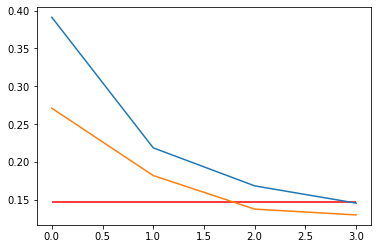

In [64]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.hlines(test_loss, 0, len(train_loss) - 1, color='red')
plt.show()

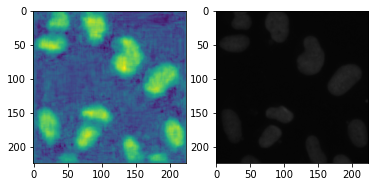

In [66]:
i = int(random.random() * len(train_dataset))
i = 55
sample = train_dataset[i]
img, target = sample.values()
model.eval()
out = model(img.unsqueeze(0).to(device))

# print(out)

f,a = plt.subplots(1,2)

a[0].imshow(out.squeeze(0).permute(1,2,0).detach().cpu().numpy())
a[1].imshow(img.permute(1,2,0)/255)
plt.show()


C:\Users\Harm\.conda\envs\thesis\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


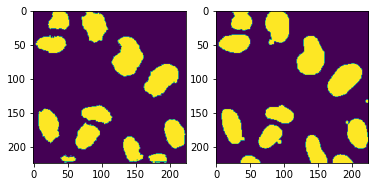

In [67]:
import torch.nn.functional as F

mask = F.sigmoid(out) >= 0.5

mask = mask.squeeze(0).squeeze(0).detach().cpu().numpy()

target = target.squeeze(0).type(torch.BoolTensor).detach().numpy()

f, a = plt.subplots(1,2)

a[0].imshow(mask)
a[1].imshow(target)

# plt.imshow(mask)
plt.show()

In [52]:
# IoU
from sklearn.metrics import jaccard_score

jaccard_score(mask.reshape(-1), target.reshape(-1))

0.7911547911547911

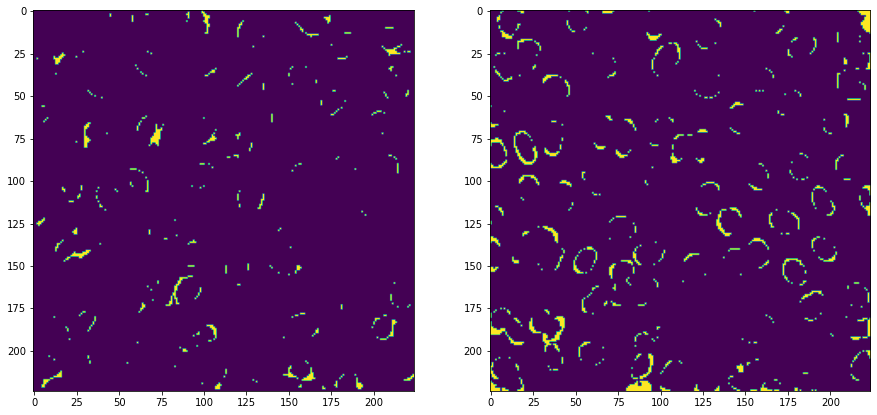

In [54]:
f,a = plt.subplots(1,2, figsize=(15,10))

a[0].imshow((mask ^ target) & mask)
a[1].imshow((mask ^ target) & target)
